# Modeling

In this notebook, I compare four linear regression models with varying regularization and provide a summary of the results.

## Importing modules and data

In [110]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
%matplotlib inline

train = pd.read_csv('../data/train_model_ready.csv')
test = pd.read_csv('../data/test_model_ready.csv')

### Create coefficient plot function

This function shows the 10 strongest positive and negative coefficients of a model on a horizontal bar plot.

In [101]:
def coef_plot(model, title):
    coef_dict = pd.DataFrame(list(dict(zip(model.best_estimator_.coef_, train[features].columns)).items()), columns=['Coef', 'Variable']).sort_values(by='Coef')
    
    bar_neg = coef_dict.sort_values('Coef').head(10)

    bar_pos = coef_dict.sort_values('Coef').tail(10)
    
    bar = bar_neg.append(bar_pos)

    fig = bar.plot.barh('Variable', 'Coef', figsize=(12, 8), legend=False, cmap='winter')
    fig.set_xlabel('Coefficient value', size=15)
    plt.xticks(size=12, rotation=90)
    plt.axhline(color='black')
    fig.set_ylabel('Variables', size=15)
    fig.set_title(f'{title} model coefficients, top and bottom 10 by magnitude')
    plt.tight_layout()

## OLS regression - pre-scaling





In [5]:
features = [x for x in train.columns if x not in ['saleprice', 'id', 'pid']]

X = train[features]
y = train.saleprice

lr = LinearRegression()

lr.fit(X, y)

lr.score(X, y)

0.9432596588641958

Our baseline score is 94% - pretty good!

#### Set up test data for modeling

In [6]:
test_features_list = [x for x in test.columns if x not in ['id', 'pid']]

test_features = test[test_features_list]

## Creating train/test splits, scaling

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [8]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

## Linear Regression

For each model, the `model.score` method returns the $R^2$/coefficient of determination for the model - the amount of variance in the data predicted by the model.

In [9]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.9516732350337583, -3.29810791762706e+20)

### Root Mean Squared Error (RMSE)

The root mean squared error is the square root of the average of the squared errors (i.e. the difference between each prediction and the actual values of home prices).

In [10]:
np.sqrt(mean_squared_error(y_test, lr.predict(X_test)))

7217392671.375601

We can see that the simple linear regression performs very poorly; the high negative R2 value for our test data means that our simple linear regression model is predicting price in a way that differs from the data. This is corroborated by the very high RMSE.

## Linear Regresssion w/ L2 Penalty (Ridge)

Introducing L2 penalty distributes error across the coefficients, minimizing coefficients for uninformative variables (but not reducing those coefficients to 0) while retaining higher coefficients for informative variables.

In [11]:
gs_ridge = GridSearchCV(Ridge(), param_grid = {'alpha': np.logspace(0, 5, 200),
                                             'random_state' : [32]})

gs_ridge.fit(X_train, y_train)
gs_ridge.score(X_train, y_train)

0.9478375317678264

In [12]:
gs_ridge.score(X_test, y_test)

0.9054343313646954

As we can see from the massive difference in $R^2$ scores (0.899 vs $-7 x 10^{-20}$), our Ridge model performs much better in comparison to the simple linear regression model.

In [13]:
np.sqrt(mean_squared_error(y_test, gs_ridge.predict(X_test)))

0.12221222530407576

In [14]:
np.expm1(np.sqrt(mean_squared_error(y_test, gs_ridge.predict(X_test))))

0.1299938896317247

RMSE for the Ridge model for price was around 14 cents.

## Plot top and bottom 10 coefficients

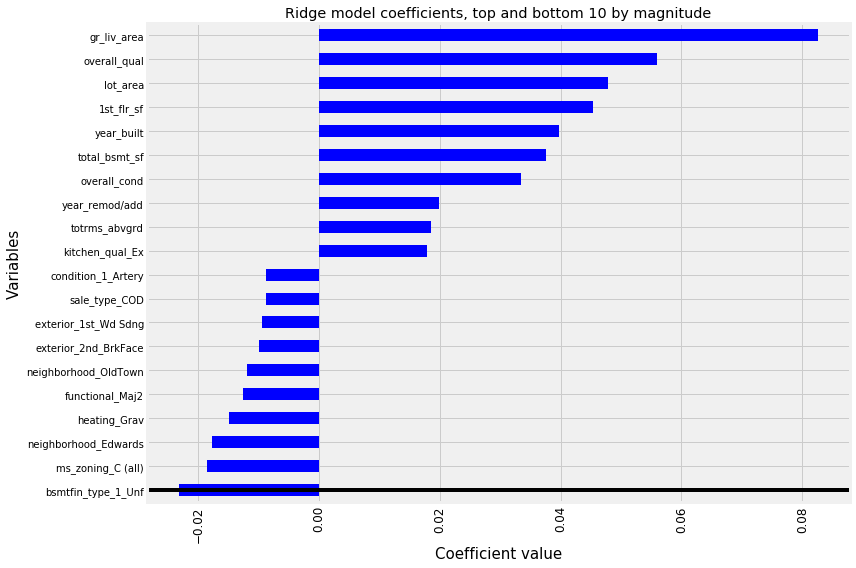

In [102]:
coef_plot(gs_ridge, 'Ridge')

**From the plot, we see that ground living area and overall quality increased price the most, while having an unfinished basement and C-class zoning reduced the price the most.**

## Linear Regression with L1 Penalty (LASSO)

The L1 penalty can be used for feature selection as it 'zeroes out' uninformative coefficients, effectively reducing the overall feature space and retaining only strongly informative variables.

In [15]:
lasso_params = {'alpha' : np.arange(0.001, 0.5, 0.005),
                'random_state': [32]}

gs_lasso = GridSearchCV(Lasso(), param_grid = lasso_params)

In [16]:
gs_lasso.fit(X_train, y_train)
gs_lasso.score(X_train, y_train), gs_lasso.score(X_test, y_test)

(0.9365483296358639, 0.9043510513082089)

In [17]:
gs_lasso.best_score_

0.9254247910105079

Our best lasso model performed quite well, with only a 2% difference in $R^2$ between train and test scores. The average of our cross-validated scores was strong as well ($R^2$ = 0.90). The LASSO model performed slightly better than the Ridge model.

In [18]:
np.sqrt(mean_squared_error(y_test, gs_lasso.best_estimator_.predict(X_test)))

0.122910222165659

In [19]:
np.expm1(np.sqrt(mean_squared_error(y_test, gs_lasso.best_estimator_.predict(X_test))))

0.1307828971506482

The RMSE for the LASSO regression was around 13 cents.

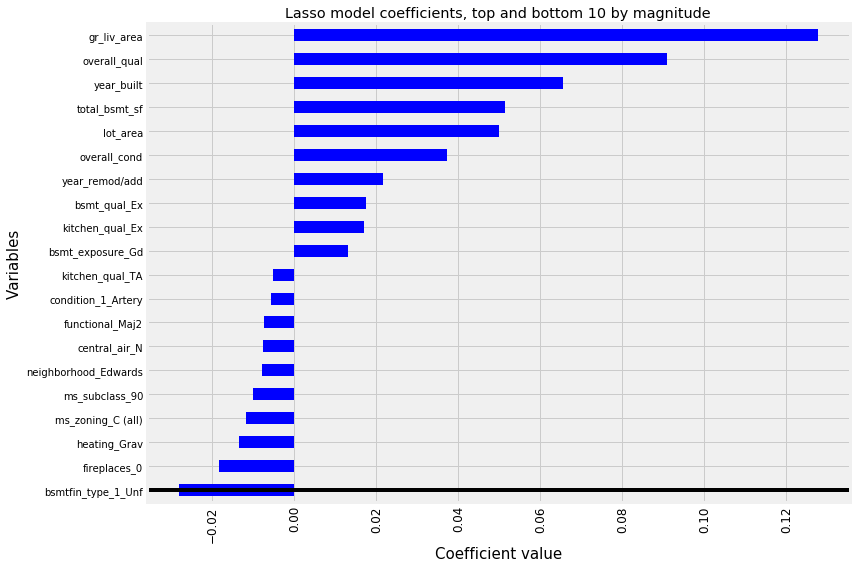

In [103]:
coef_plot(gs_lasso, 'Lasso')

Like in the Ridge model, ground living area and overall quality were the strongest positive predictors for price. There were differences in the negative factors; lack of a fireplace and having a gravity heating system reduced predicted price.

## Elastic Net

The Elastic Net strategy introudces both L1 and L2 penalties and attempts to find a balance between the extreme feature selection of L1 and smoothing nature of L2.

In [104]:
el_params = {'alpha': np.arange(0.01, 1.0, 0.05),
             'l1_ratio': np.arange(0.01, 1.0, 0.05)}

gs_el = GridSearchCV(ElasticNet(), param_grid = el_params)

gs_el.fit(X_train, y_train)
gs_el.score(X_train, y_train), gs_el.score(X_test, y_test)

(0.9420753943165155, 0.9077255040007765)

In [105]:
np.sqrt(mean_squared_error(y_test, gs_el.predict(X_test)))

0.12072264554488969

In [106]:
np.expm1(np.sqrt(mean_squared_error(y_test, gs_el.predict(X_test))))

0.12831192662575172

In [107]:
gs_el.best_score_

0.9264822845284044

Our elastic net model performed slightly better than the lasso model ($R^2$ = 0.908 for Elastic Net vs $R^2$ = 0.904 for Lasso).

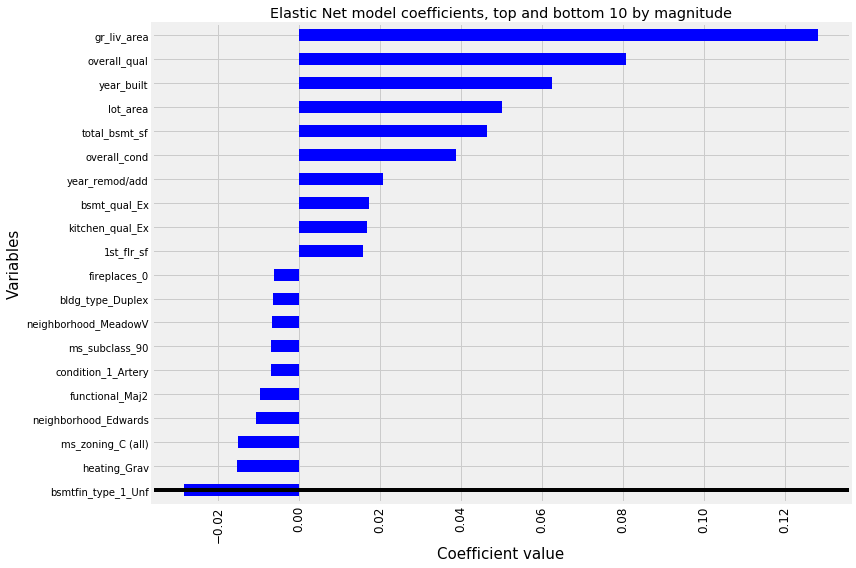

In [109]:
coef_plot(gs_el, 'Elastic Net')

**We see similar results to the Lasso and Ridge models from our coefficient plot for Elastic Net; ground living area remains the strongest positive predictor while having an unfinished basement remains the strongest negative factor.**

## Summary

| Model                                 	| R2 (train) 	| R2 (test)       	| RMSE (USD) 	|
|---------------------------------------	|------------	|-----------------	|------------	|
| Linear Regression (no regularization) 	| 0.952      	| -3.3 x 10^-20 	| 7.2x10^9   	|
| Ridge (L2 penalty)                    	| 0.947      	| 0.905           	| 0.130      	|
| Lasso (L1 penalty)                    	| 0.937      	| 0.904           	| 0.131      	|
| Elastic Net                           	| 0.942      	| 0.908           	| 0.128      	|

In summary, our feature selection strategy appears to have performed quite well as the different types of regularization return similar (but not exactly the same) results. With a RMSE of less than 25 cents, we should be confident that our model can perform adequately when predicting house prices in Ames, Iowa provided enough information about the house features.